In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
!pip install xgboost
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

# MODELS

## Load pre-processed data

In [5]:
formatted_data = pd.read_csv('formatted_data.csv',sep=";")

In [6]:
features = formatted_data.drop(columns=['Target'])
target = formatted_data['Target']

## Random Seed

In [7]:
RANDOM_SEED = 42

## k-Fold Validation

In [8]:
k = 5
cv = StratifiedKFold(n_splits=k, random_state=RANDOM_SEED, shuffle=True)

### ROC Plotting Function


In [9]:
def plot_roc_curve(fprs, tprs, figsize=(14, 10)):
    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots(figsize=figsize)

    for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Luck', alpha=.8)

    mean_tpr = np.mean([np.interp(mean_fpr, fpr, tpr) for fpr, tpr in zip(fprs, tprs)], axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std([auc(fpr, tpr) for fpr, tpr in zip(fprs, tprs)])
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std([np.interp(mean_fpr, fpr, tpr) for fpr, tpr in zip(fprs, tprs)], axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')
    ax.legend(loc="lower right")
    plt.show()
    return fig, ax

In [10]:
def compute_roc_auc(clf, X, y, index):
    y_predict = clf.predict_proba(X.iloc[index])[:, 1]
    fpr, tpr, thresholds = roc_curve(y.iloc[index], y_predict)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score

In [11]:
def train_and_show_auc(clf, X, y):
    fprs, tprs, scores = [], [], []

    for (train, test), i in zip(cv.split(X, y), range(5)):
        clf.fit(X.iloc[train], y.iloc[train])
        _, _, auc_score_train = compute_roc_auc(clf, X, y, train)
        fpr, tpr, auc_score = compute_roc_auc(clf, X, y, test)
        scores.append((auc_score_train, auc_score))
        fprs.append(fpr)
        tprs.append(tpr)

    plot_roc_curve(fprs, tprs)
    return pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'])

## Random Forests

In [12]:
rf_classifier = RandomForestClassifier(random_state=RANDOM_SEED)

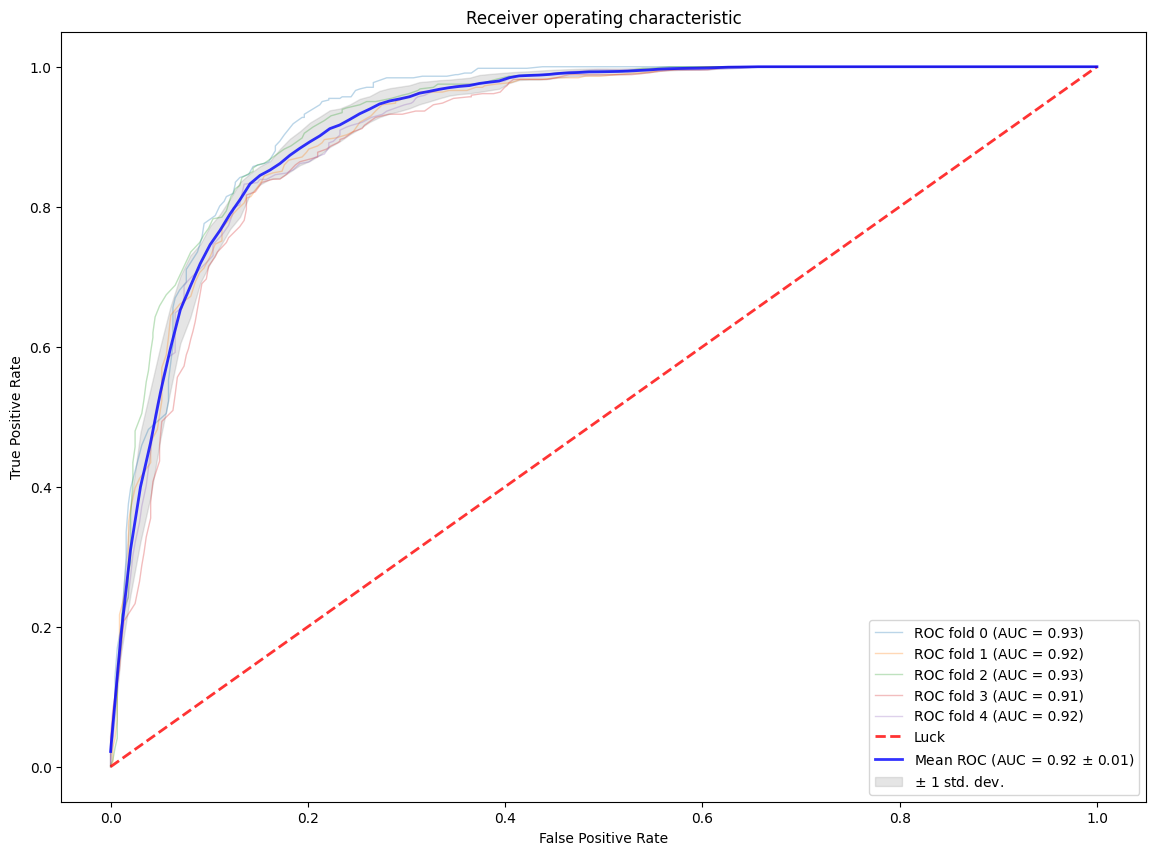

In [13]:
rf_scores = train_and_show_auc(rf_classifier, features, target)

## Gradient Boosting

In [14]:
xgb_classifier = xgb.XGBClassifier(random_state=RANDOM_SEED)

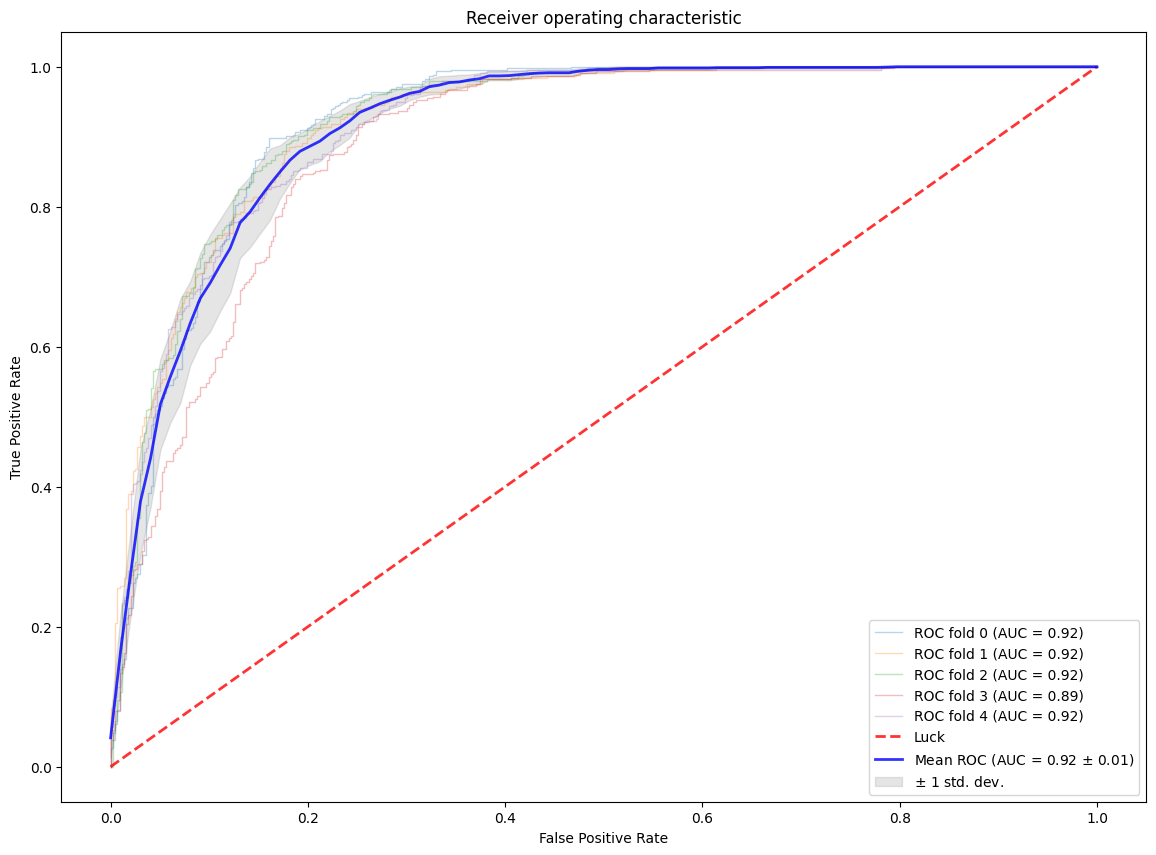

In [15]:
xgb_scores = train_and_show_auc(xgb_classifier, features, target)

In [42]:
!pip install shap
import shap

In [17]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

# Assuming 'features' and 'target' are already defined and preprocessed
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

xgb_classifier = xgb.XGBClassifier(random_state=42)
xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

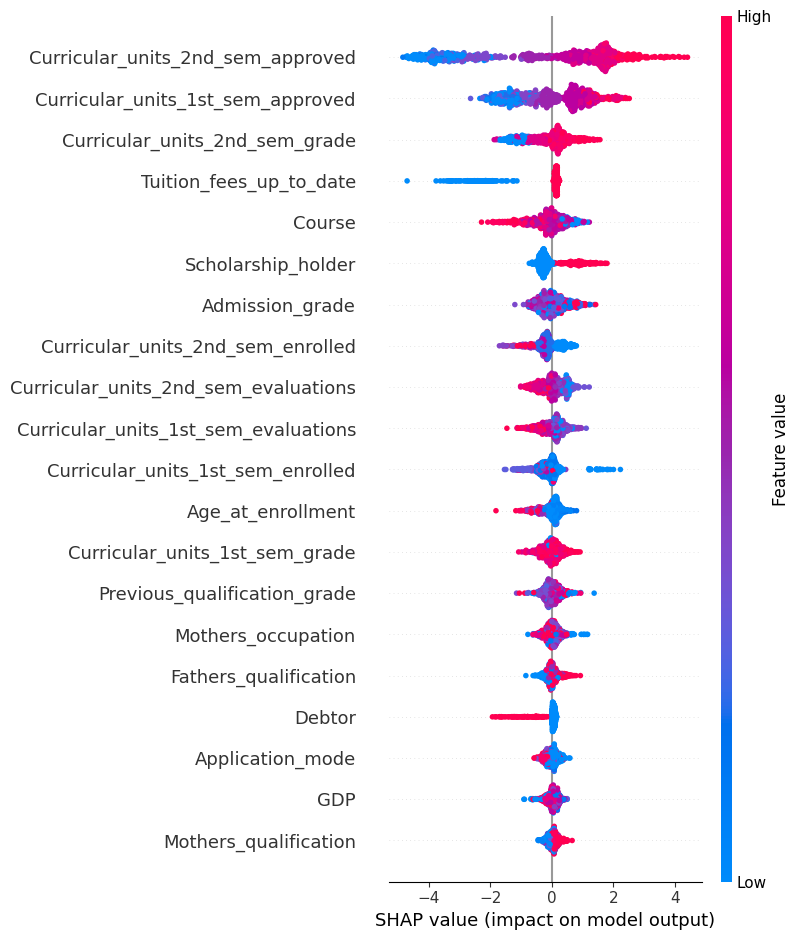

In [29]:
# Initialize SHAP explainer with the fitted model
explainer = shap.Explainer(xgb_classifier)
shap_values = explainer(X_test)

# Plot global summary to understand the impact of each feature
# Note that not all features are in here, only the ones with the greatest contributions
shap.summary_plot(shap_values, X_test)

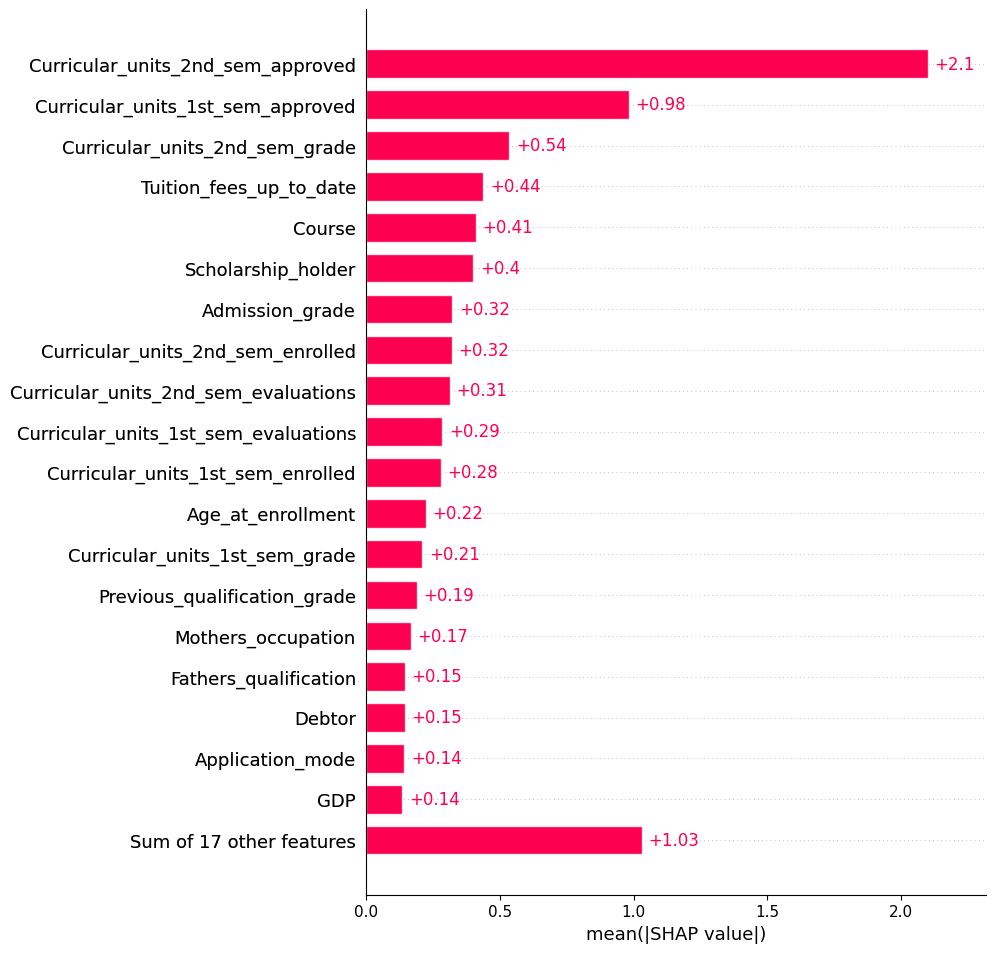

In [41]:
# Can be compared to the other importances we found
shap.plots.bar(shap_values, max_display=20)

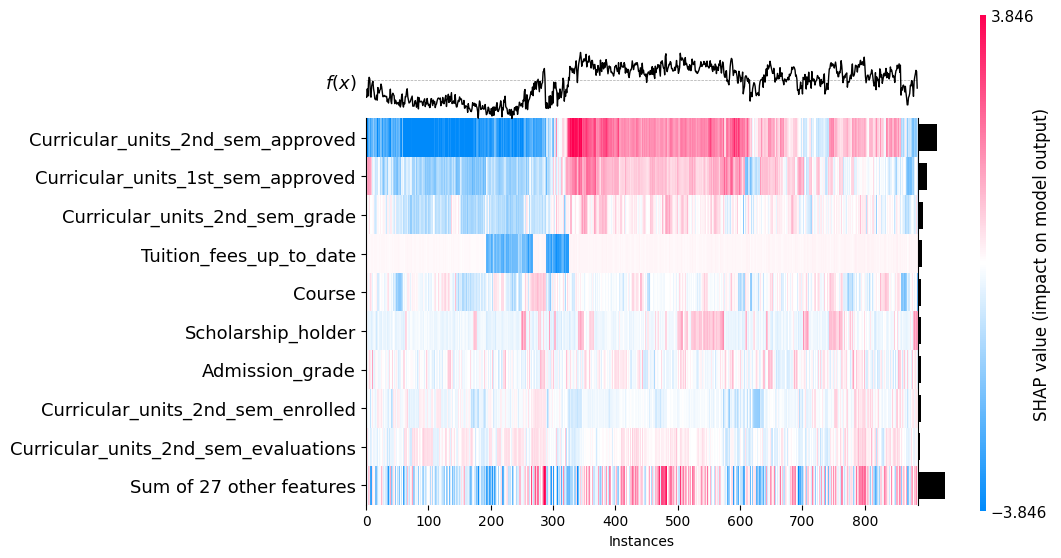

In [39]:
# Somehting strange here, why are the first instances of negative impact?
shap.plots.heatmap(shap_values)

## SVM

In [20]:
svm_classifier = SVC(random_state=RANDOM_SEED, probability=True)

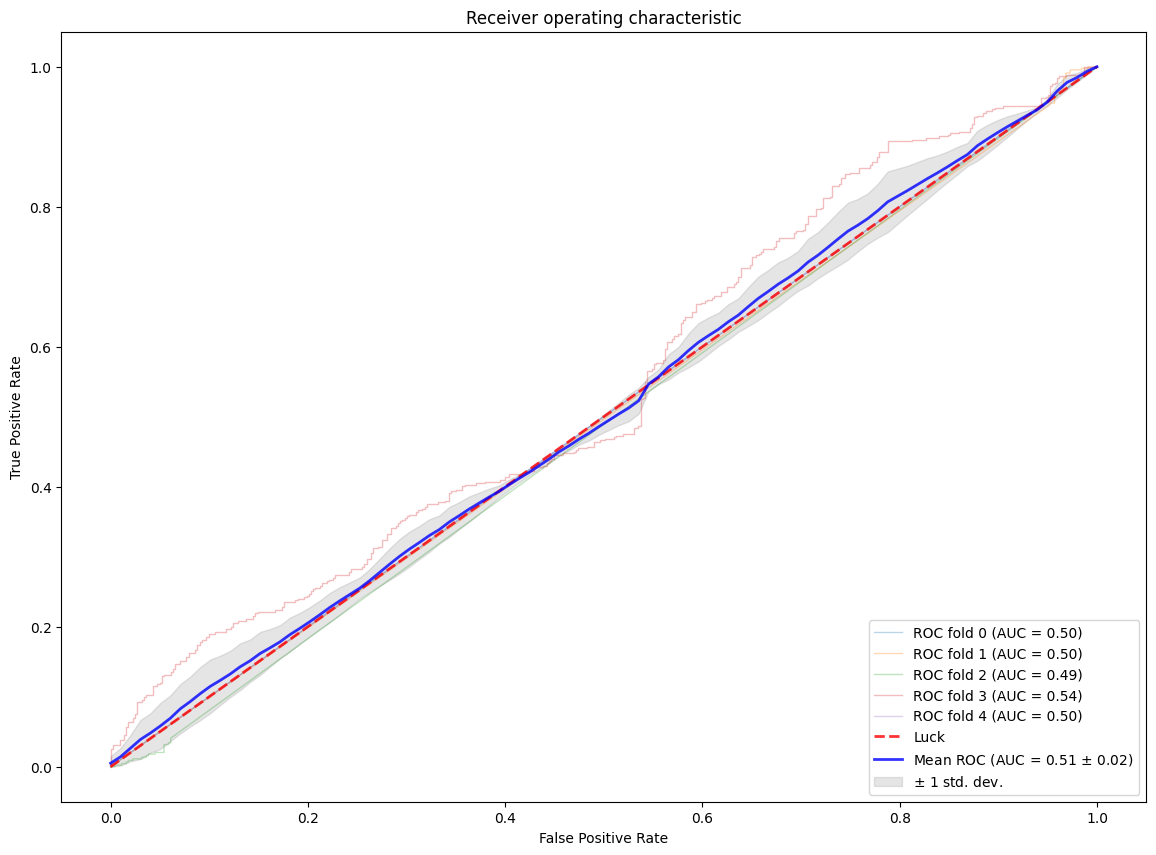

In [21]:
svm_scores = train_and_show_auc(svm_classifier, features, target)

## Logistic Regression

In [22]:
lr_classifier = LogisticRegression(random_state=RANDOM_SEED, max_iter=1000)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

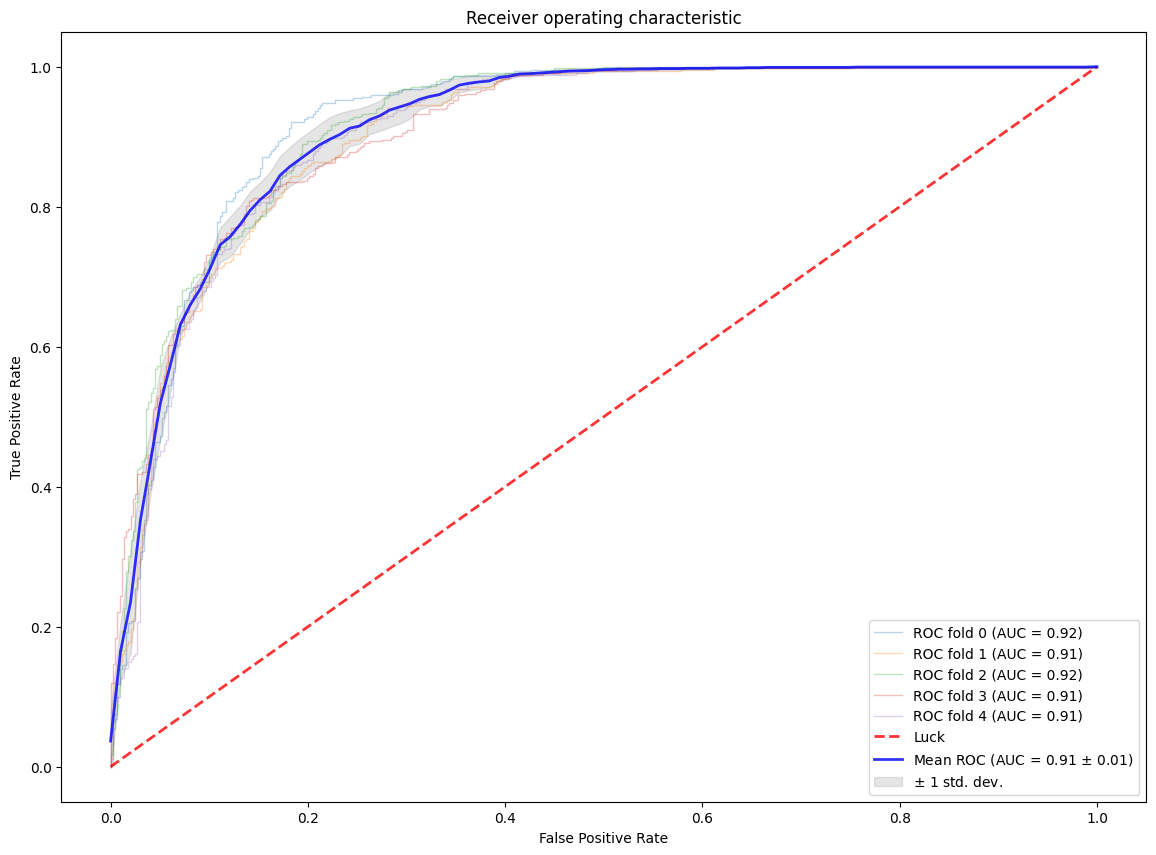

In [23]:
lr_scores = train_and_show_auc(lr_classifier, features, target)

## Neural Network

In [24]:
mlp_classifier = MLPClassifier(random_state=RANDOM_SEED)

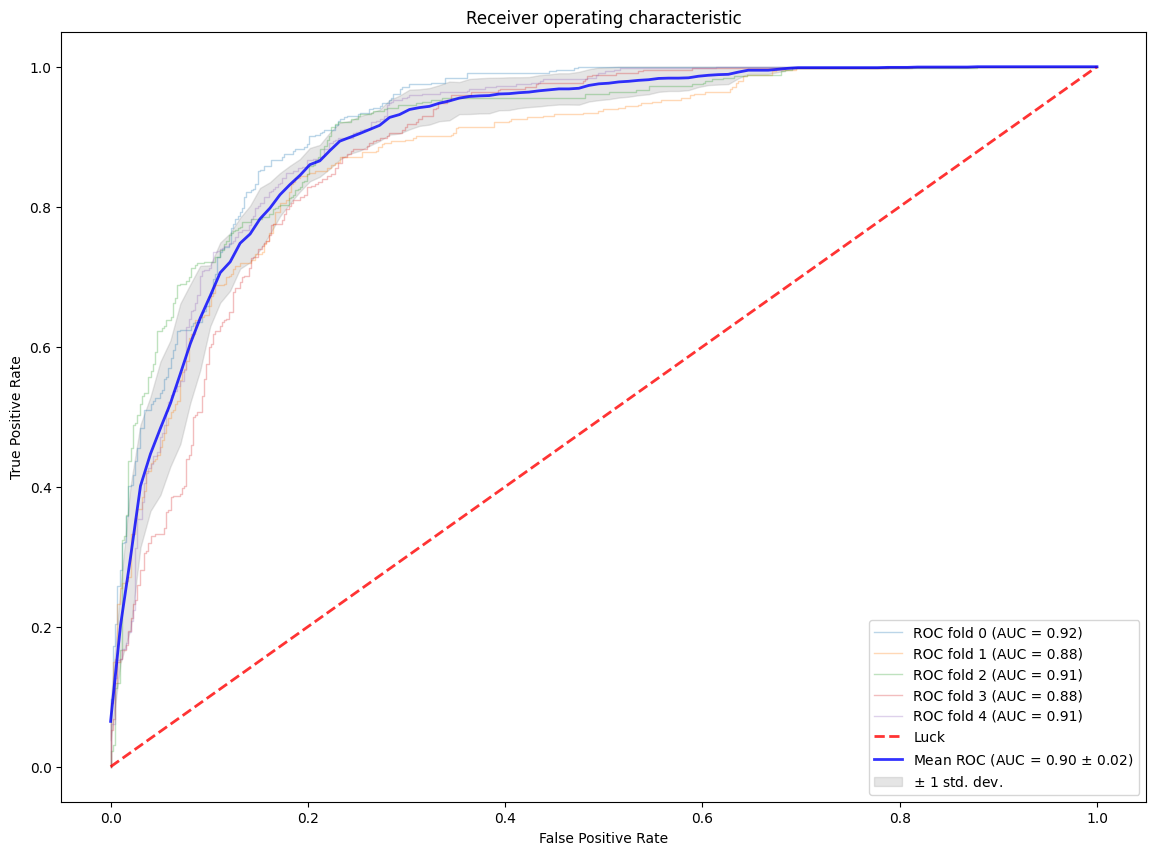

In [25]:
mlp_scores = train_and_show_auc(mlp_classifier, features, target)